PACKAGE FOR MOUNTING THE GOOGLE DRIVE WITH CO-LAB


In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


IMPORTING THE REQUIRED PACKAGES
ASSIGNING IMPORTANT PARAMETERS SUCH AS 
BATCH_SIZE, EPOCHES, IMAGES RESIZING PIXEL SIZE, LEARNING RATE FOR BACK PROPOGATION AND DIRECTORY FOR THE AUGMENTED DATA 

In [ ]:

import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from  tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image_dataset_from_directory

path='/content/drive/MyDrive/data_mask'


BATCH_SIZE = 32
init_epochs=3
fine_tuning_epochs=8
IMG_SIZE = (224, 224)
base_learning_rate=0.0001



PRE-PROCESSING THE AUGMENTED DATA AND SPLITTING TRAINING, TESTING AND VALIDATION DATASET 
PRE-PROCESSING :
-->SHUFFLING
--> RE-SIZING THE IMAGES
--> ASSIGNING THE RATIO OF SPLITTING THE DATASET


In [ ]:
train_dataset = image_dataset_from_directory(path,
                                             shuffle=True,
                                             subset='training',
                                             seed=1,
                                             validation_split=0.2,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 13603 files belonging to 2 classes.
Using 10883 files for training.


In [ ]:
validation_dataset = image_dataset_from_directory(path,
                                             shuffle=True,
                                             subset='validation',
                                             seed=1,
                                             validation_split=0.2,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 13603 files belonging to 2 classes.
Using 2720 files for validation.


In [ ]:
VISUALIZINNG THE IMAGES IN MATRIX FORM


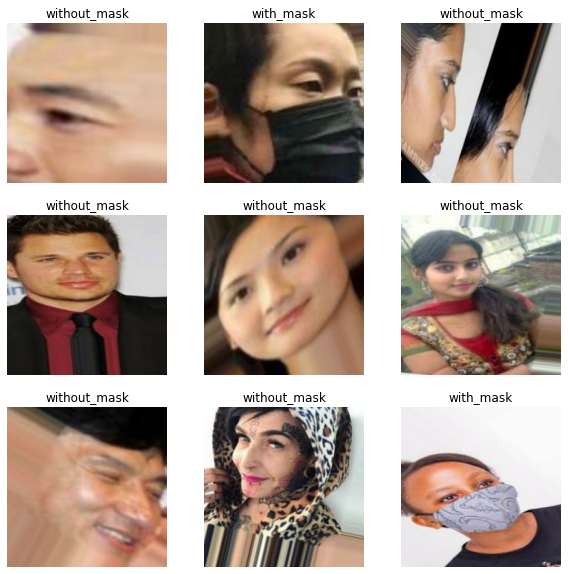

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches//5)
validation_dataset = validation_dataset.skip(val_batches//5)

SMOOTHENING THE IMAGES BY TUNING IT TO REDUCE THE FEATURES WHICH REDUCES THE FUNCTIONALITY

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
len(train_dataset),len(validation_dataset),len(test_dataset)

(341, 68, 17)

SECOND AUGMENTATION IS PERFORMED TO REDUCE THE OVERFITTING ISSUE

In [ ]:
data_augmentation=tf.keras.Sequential([

    tf.keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal'),

    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),

    tf.keras.layers.experimental.preprocessing.RandomZoom(.5, .2),

    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),

    tf.keras.layers.experimental.preprocessing.RandomContrast(factor=0.1),
])

In [ ]:
image, label = next(iter(validation_dataset))
len(image)

32

VISUALIZING ALL THE MANUPLATION HAPPENING WHILE AUGMENTATION IS PERFORMED 

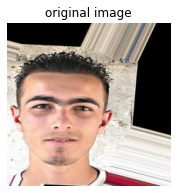

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


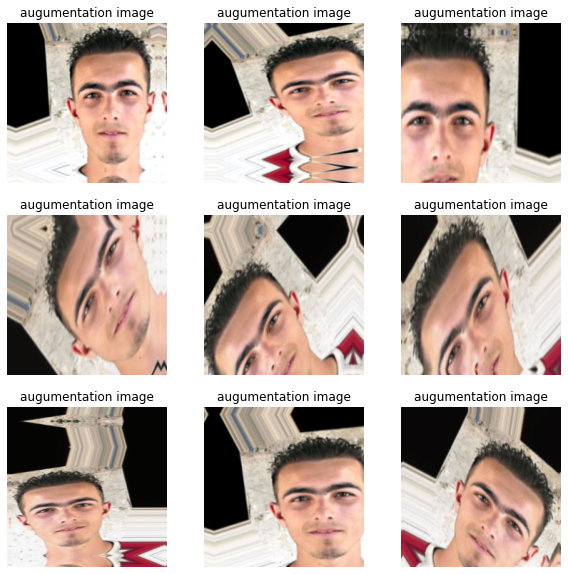

In [ ]:
plt.figure(figsize=(3,3))
plt.imshow(image[3].numpy().astype('uint8'))
plt.title("original image")
plt.axis("off")
plt.show()
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    data_aug_image=data_augmentation(tf.expand_dims(image[3],0))
    plt.imshow(data_aug_image[0]/255.0)
    plt.title("augumentation image")
    plt.axis("off")
plt.show()

MODEL 4 - EfficientNetB0(DOWNLODIING THE WEIGHTS AND IMPORTING THE MODEL)

In [ ]:
image_shape=IMG_SIZE+(3,)
base_model=tf.keras.applications.EfficientNetB0(input_shape=image_shape,
                                    include_top=False,
                                    weights='imagenet',
                                    drop_connect_rate=0.4)




TRAINING THE MODEL AND WEIGHTS ARE RESTRUCTED BY THE BELOW SYNTAX BECAUSE ITS A TRANSFER LEARNING MODEL. ONLY THE FINAL CLASSIFICATION DENSE LAYER IS TRAINED 

In [ ]:
base_model.trainable=False

In [ ]:
model=tf.keras.Sequential()
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(1))

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d_11  (None, 1280)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 1281      
Total params: 4,050,852
Trainable params: 1,281
Non-trainable params: 4,049,571
_________________________________________________________________


BUILDING THE FINAL VGG16 WITH  ADDITIONAL LAYER  MODEL 

In [ ]:
input=tf.keras.Input(image_shape)
x=data_augmentation(input)
x=base_model(x,training=False)
x=tf.keras.layers.GlobalAveragePooling2D()(x)
x=tf.keras.layers.Dropout(0.2)(x)
x=tf.keras.layers.BatchNormalization()(x)
output=tf.keras.layers.Dense(1)(x)
model=tf.keras.Model(input,output)

VISUALIZING THE LAYERS, NO OF NEURAL NETWORK AND COMPUTATION 

In [ ]:
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_7 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d_12  (None, 1280)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1280)              0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 1280)              5120      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 1281

MODEL.COMPILE- SYNTAX FOR BACK PROPOGATION AND REDUCING THE LOSS 

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
len(train_dataset),len(validation_dataset),len(test_dataset)

(341, 68, 17)

FITTING THE MODEL FOR TRAINING WITH TRAINIG DATASET AND VALIDATION WITH THE VALIDATION DATASE

In [ ]:
history=model.fit(train_dataset,
          epochs=init_epochs,
          validation_data=validation_dataset
         )

Epoch 1/3
341/341 [==============================] - 69s 179ms/step - loss: 0.2392 - accuracy: 0.8941 - val_loss: 0.0435 - val_accuracy: 0.9894
Epoch 2/3
341/341 [==============================] - 60s 175ms/step - loss: 0.1545 - accuracy: 0.9348 - val_loss: 0.0312 - val_accuracy: 0.9903
Epoch 3/3
341/341 [==============================] - 60s 175ms/step - loss: 0.1423 - accuracy: 0.9439 - val_loss: 0.0259 - val_accuracy: 0.9917


VISUALIZING THE ACCURACY AND LOSS IN EACH EPOCHES OR CYCLES

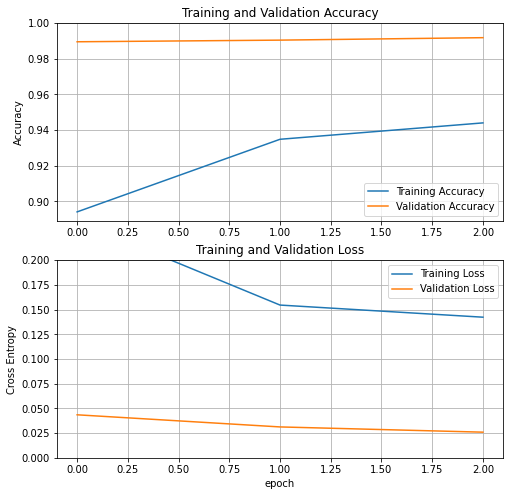

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,0.2])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.grid()
plt.show()

MODEL 2 - VVG16 (DOWNLODIING THE WEIGHTS AND IMPORTING THE MODEL)

In [ ]:
image_shape=IMG_SIZE+(3,)
base_model_2=tf.keras.applications.VGG16(input_shape=image_shape,
                                    include_top=False,
                                    weights='imagenet',)
                                    #drop_connect_rate=0.4)

TRAINING THE MODEL AND WEIGHTS ARE RESTRUCTED BY THE BELOW SYNTAX BECAUSE ITS A TRANSFER LEARNING MODEL. ONLY THE FINAL CLASSIFICATION DENSE LAYER IS TRAINED 

In [ ]:
base_model_2.trainable=False

In [ ]:
model_2=tf.keras.Sequential()
model_2.add(base_model_2)
model_2.add(tf.keras.layers.GlobalAveragePooling2D())
model_2.add(tf.keras.layers.Dense(1))

In [ ]:
model_2.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_13  (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 513       
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_________________________________________________________________


BUILDING THE FINAL VGG16 WITH  ADDITIONAL LAYER  MODEL 


In [ ]:
input=tf.keras.Input(image_shape)
x=data_augmentation(input)
x=base_model_2(x,training=False)
x=tf.keras.layers.GlobalAveragePooling2D()(x)
x=tf.keras.layers.Dropout(0.2)(x)
x=tf.keras.layers.BatchNormalization()(x)
output=tf.keras.layers.Dense(1)(x)
model_2=tf.keras.Model(input,output)

VISUALIZING THE LAYERS, NO OF NEURAL NETWORK AND COMPUTATION 


In [ ]:
model_2.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_7 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_14  (None, 512)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 512)               2048      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 513 

MODEL.COMPILE- SYNTAX FOR BACK PROPOGATION AND REDUCING THE LOSS 


In [ ]:
model_2.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# len(train_dataset),len(validation_dataset),len(test_dataset)

(341, 68, 17)

FITTING THE VGG 16 MODEL WITH THE TRAIN DATASET AND VALIDATING WITH THE VALIDATION DATASET

In [ ]:
history=model_2.fit(train_dataset,
          epochs=init_epochs,
          validation_data=validation_dataset
         )

Epoch 1/3
341/341 [==============================] - 112s 321ms/step - loss: 0.4510 - accuracy: 0.7804 - val_loss: 0.2107 - val_accuracy: 0.9122
Epoch 2/3
341/341 [==============================] - 110s 320ms/step - loss: 0.3078 - accuracy: 0.8600 - val_loss: 0.1580 - val_accuracy: 0.9398
Epoch 3/3
341/341 [==============================] - 110s 322ms/step - loss: 0.2861 - accuracy: 0.8739 - val_loss: 0.1406 - val_accuracy: 0.9416


VISUALIZING THE ACCURACY AND LOSS IN EACH EPOCHES OR CYCLES


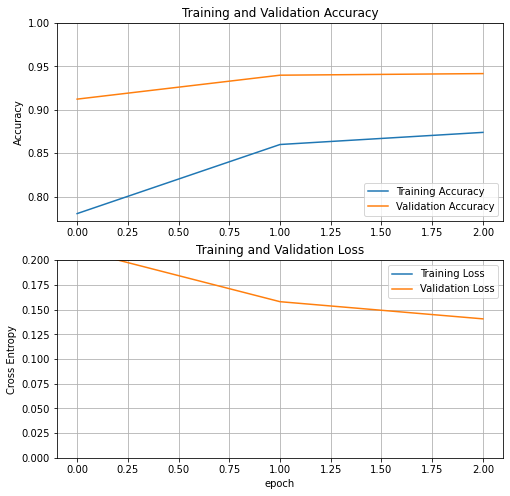

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.grid()
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,0.2])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.grid()
plt.show()

MODEL 3- VGG19
DOWNLODING THE WEIGHTS FOR VGG19 FROM IMAGENET AND IMPORTING THE MODEL

In [ ]:
image_shape=IMG_SIZE+(3,)
base_model_3=tf.keras.applications.VGG19(input_shape=image_shape,
                                    include_top=False,
                                    weights='imagenet',)

80150528/80134624 [==============================] - 1s 0us/step


In [ ]:
base_model_3.trainable=False

In [ ]:
model_3=tf.keras.Sequential()
model_3.add(base_model_3)
model_3.add(tf.keras.layers.GlobalAveragePooling2D())
model_3.add(tf.keras.layers.Dense(1))

In [ ]:
model_3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 20,024,897
Trainable params: 513
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
input=tf.keras.Input(image_shape)
x=data_augmentation(input)
x=base_model_3(x,training=False)
x=tf.keras.layers.GlobalAveragePooling2D()(x)
x=tf.keras.layers.Dropout(0.2)(x)
x=tf.keras.layers.BatchNormalization()(x)
output=tf.keras.layers.Dense(1)(x)
model_3=tf.keras.Model(input,output)

In [ ]:
model_3.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513   

In [ ]:
model_3.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
len(train_dataset),len(validation_dataset),len(test_dataset)

(341, 68, 17)

In [ ]:
history=model_3.fit(train_dataset,
          epochs=init_epochs,
          validation_data=validation_dataset
         )


Epoch 1/3
341/341 [==============================] - 3878s 11s/step - loss: 0.4697 - accuracy: 0.7664 - val_loss: 0.1983 - val_accuracy: 0.9210
Epoch 2/3
341/341 [==============================] - 127s 372ms/step - loss: 0.3123 - accuracy: 0.8635 - val_loss: 0.1489 - val_accuracy: 0.9412
Epoch 3/3
341/341 [==============================] - 127s 371ms/step - loss: 0.2891 - accuracy: 0.8740 - val_loss: 0.1243 - val_accuracy: 0.9522


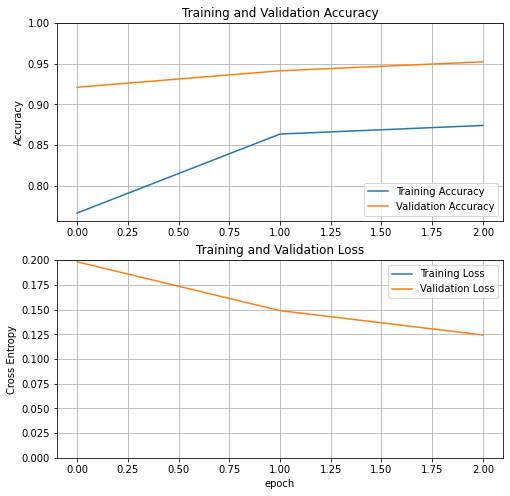

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.grid()
plt.ylim([min(plt.ylim()),1])

plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,0.2])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.grid()
plt.show()

custom CNN

###EXTRACTION MODEL

In [ ]:
# MyCnn.save('model.h5')

### Load Model

In [ ]:
# del model
# model=load_model(os.path.join(output_path,"face_mask_detection.h5"))